In [1]:
import sys
sys.path.insert(0, 'utils')
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import ds_charts as ds
from ds_charts import plot_evaluation_results
import itertools as it
import timeit
import os



%matplotlib inline

/home/rodrirocki/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:

dataset = 'crime'
suffix = 'crime_dankfe3'
file_name = ''

data_dir = f'data/{dataset}/'
image_dir = f'images/{dataset}/{suffix}/'

if not os.path.exists(data_dir):
        os.mkdir(data_dir)
if not os.path.exists(image_dir):
        os.mkdir(image_dir)

train_test_avaliable = True

if train_test_avaliable:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}_train.csv',parse_dates=['current_date'], infer_datetime_format=True)
        test = pd.read_csv(f'{data_dir}{file_name}{suffix}_test.csv',parse_dates=['current_date'], infer_datetime_format=True)
else:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}.csv',parse_dates=['current_date'], infer_datetime_format=True)

In [3]:
# Tratamento de missing values

le = LabelEncoder()

# train = train.drop(columns=['ratio'])
# train = train.dropna(subset=['high_risk_2w'])
# train = train.dropna(subset=['renewable_percentage'])

variable_types = ds.get_variable_types(train)
print(variable_types)

train = train.drop(columns=variable_types['Date'])
# train['country'] = le.fit_transform(train['country'])
# train['city'] = le.fit_transform(train['city'])
# train['weapon'] = le.fit_transform(train['weapon'])
# train['district'] = le.fit_transform(train['district'])
# train['neighborhood'] = le.fit_transform(train['neighborhood'])
# train['description'] = le.fit_transform(train['description'])
print(train.isna().sum()[train.isna().sum() != 0])

if train_test_avaliable:
    test = test.drop(columns=variable_types['Date'])
    # test['country'] = le.fit_transform(test['country'])
    # test['city'] = le.fit_transform(test['city'])
    # test['weapon'] = le.fit_transform(test['weapon'])
    # test['district'] = le.fit_transform(test['district'])
    # test['description'] = le.fit_transform(test['description'])
    # train['neighborhood'] = le.fit_transform(train['neighborhood'])
    # test['neighborhood'] = le.fit_transform(test['neighborhood'])
    print(test.isna().sum()[test.isna().sum() != 0])



{'Numeric': ['weapon', 'post', 'lat', 'lon', 'dist_center', 'day_period', 'crime_type', 'neighborhood_lat', 'neighborhood_lon', 'district_lat', 'district_lon', 'current_date_day', 'current_date_month', 'current_date_year', 'current_date_season', 'current_date_weekday'], 'Binary': ['inside', 'common_dist'], 'Date': ['current_date'], 'Symbolic': []}
Series([], dtype: int64)
Series([], dtype: int64)


In [4]:
target = 'common_dist'
positive = 1
negative = 0

if train_test_avaliable:
    trnY: np.ndarray = train.pop(target).values
    trnX: np.ndarray = train.values
    tstY: np.ndarray = test.pop(target).values
    tstX: np.ndarray = test.values
    labels: np.ndarray = pd.unique(trnY)
else:
    y = train.pop(target).values
    X = train.values
    labels: np.ndarray = pd.unique(y)

model_scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}

In [5]:
# TEST CONFIGURATIONS
train_config = {
    'KNN' : True,
    'DT' : True,
    'RF' : True,
    'GB' : True,
    'iterations' : 10,
}

times = {
    'NB' : {'fit': [], 'pred': []},
    'KNN' : {'fit': [], 'pred': [], 'param': []},
    'DT' : {'fit': [], 'pred': [], 'param': []},
    'RF' : {'fit': [], 'pred': [], 'param': []},
    'GB' : {'fit': [], 'pred': [], 'param': []},
}

model_importances = {
    'DT' : [],
    'RF' : [],
    'GB' : [],
}

In [6]:
def get_scores_fold(y_train,y_prediction,store,model):
    store[model]['precision'].append(metrics.precision_score(y_train,y_prediction))
    store[model]['recall'].append(metrics.recall_score(y_train,y_prediction))
    store[model]['accuracy'].append(metrics.accuracy_score(y_train,y_prediction))
    store[model]['auc'].append(metrics.roc_auc_score(y_train,y_prediction))
    store[model]['F1'].append(metrics.f1_score(y_train,y_prediction))
    return store

In [7]:
def get_best_params(model,params, X, y,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            print(i, end= ' ')
            trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        # print(f"Parameter time: {timeit.default_timer() - start_time}")
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

def get_best_params_train_test(model,params, trnX, trnY, tstX, tstY ,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            # print(i, end= ' ')
            # trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

0 zfit time: 0.5352470000000267
zpredict: 0.01595610000003944
1 zfit time: 0.3995390000000043
zpredict: 0.03106999999999971
2 zfit time: 0.026847600000110106
zpredict: 0.016648399999894536
3 zfit time: 0.0246177000001353
zpredict: 0.014138000000002648
4 zfit time: 0.02596399999993082
zpredict: 0.018694399999958478
5 zfit time: 0.021594600000071296
zpredict: 0.009356999999909021
6 zfit time: 0.03415010000003349
zpredict: 0.009532399999898189
7 zfit time: 0.033990099999982704
zpredict: 0.01733220000005531
8 zfit time: 0.021860500000002503
zpredict: 0.00784069999986059
9 zfit time: 0.027343599999994694
zpredict: 0.010991399999966234


<Figure size 600x450 with 0 Axes>

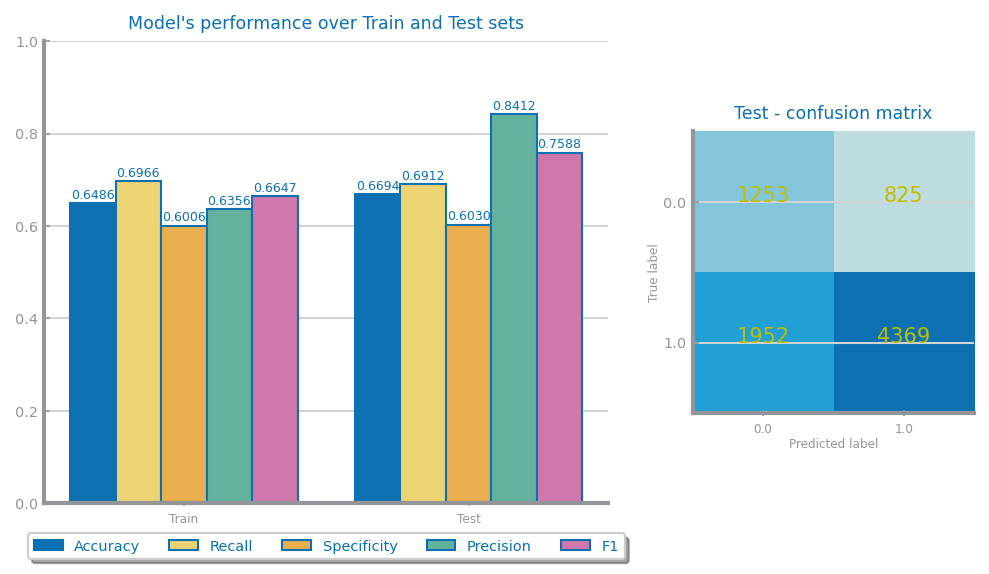

In [8]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

iterations = train_config['iterations']

fit_time = []
pred_time = []
nb_train_predictions = []
nb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_nb = BernoulliNB()
counter = 0
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
    start_time = timeit.default_timer()
    clf_nb.fit(trnX, trnY)
    times['NB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_nb.predict(trnX)
    # print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_nb.predict(tstX)
    times['NB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    nb_train_predictions.append(prd_trn)
    nb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'NB')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}NB.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.005573000000140382
train_predict time: 8.39556379999999
zpredict: 2.4738523000000896
1 zfit time: 0.0037993000000824395
train_predict time: 8.491053199999897
zpredict: 2.6270383999999467
2 zfit time: 0.0056861000000481
train_predict time: 8.217294000000038
zpredict: 2.3847805000000335
3 zfit time: 0.004832699999951728
train_predict time: 8.287240299999894
zpredict: 2.472727500000019
4 zfit time: 0.008981100000028164
train_predict time: 8.656235799999877
zpredict: 2.5921957000000475
5 zfit time: 0.006245900000067195
train_predict time: 8.510759199999939
zpredict: 2.683236900000111
6 zfit time: 0.0035233000000971515
train_predict time: 8.423129000000017
zpredict: 2.6324463999999352
7 zfit time: 0.004659899999978734
train_predict time: 8.254188200000044
zpredict: 2.415596399999913
8 zfit time: 0.0053209999998671265
train_predict time: 8.516581000000087
zpredict: 2.565150899999935
9 zfit time: 0.005921600000192484
train_predict time: 8.779879400000027
zpredict: 2.60118850000

<Figure size 600x450 with 0 Axes>

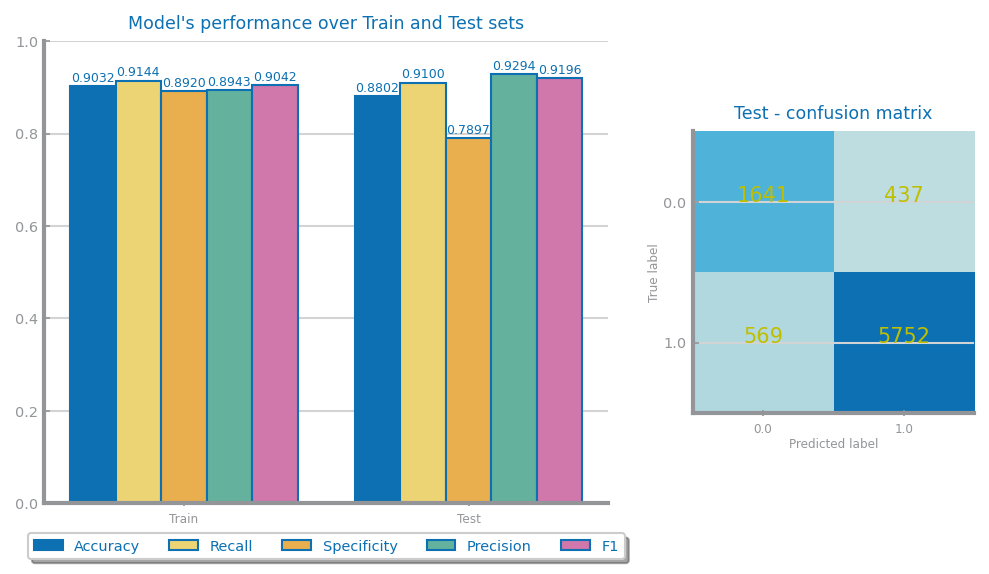

In [9]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
iterations = train_config['iterations']
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['manhattan', 'euclidean', 'chebyshev'],
}

model = KNeighborsClassifier(n_jobs=-1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)

knn_train_predictions = []
knn_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1], n_jobs = -1)
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_knn.fit(trnX, trnY)
    times['KNN']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_knn.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_knn.predict(tstX)
    times['KNN']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    knn_train_predictions.append(prd_trn)
    knn_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'KNN')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}knn.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.12245849999999336
train_predict time: 0.002551100000118822
zpredict: 0.0008743999999296648
1 zfit time: 0.12364830000001348
train_predict time: 0.002792600000020684
zpredict: 0.0008843000000524626
2 zfit time: 0.1197240999999849
train_predict time: 0.0024419000001216773
zpredict: 0.0009978000000501197
3 zfit time: 0.12469839999994292
train_predict time: 0.0023796000000402273
zpredict: 0.0009924999999384454
4 zfit time: 0.14313819999983934
train_predict time: 0.0023794000001089444
zpredict: 0.0008636000000024069
5 zfit time: 0.15837790000000496
train_predict time: 0.0032929000001331588
zpredict: 0.002018299999917872
6 zfit time: 0.11879980000003343
train_predict time: 0.0025854000000435917
zpredict: 0.001849700000093435
7 zfit time: 0.13189790000001267
train_predict time: 0.0023559999999633874
zpredict: 0.0009657000000515836
8 zfit time: 0.15091419999998834
train_predict time: 0.0046727999999802705
zpredict: 0.0010960999998133047
9 zfit time: 0.2369363999998768
train_pred

<Figure size 600x450 with 0 Axes>

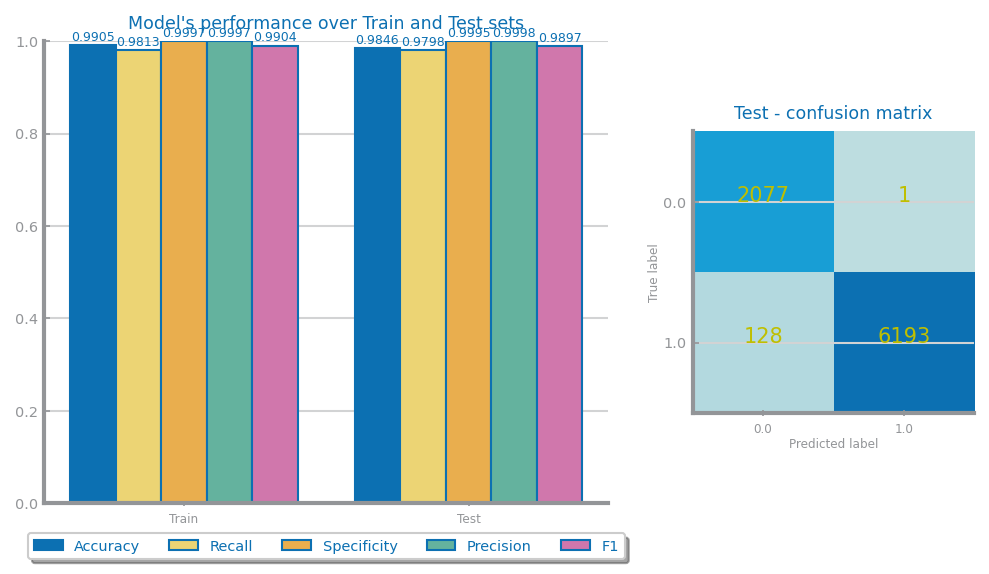

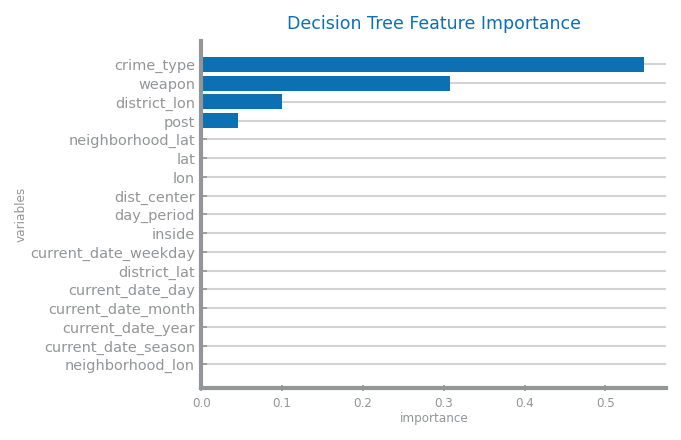

In [10]:
#  DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree
iterations = train_config['iterations']
params = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.025, 0.01, 0.005, 0.0025, 0.001],
    'max_depth': [2, 5, 10, 15, 20, 25],
}

model = DecisionTreeClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)

dt_train_predictions = []
dt_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_dt = DecisionTreeClassifier(criterion=best[0],min_impurity_decrease=best[1],max_depth=best[2],random_state=0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_dt.fit(trnX, trnY)
    times['DT']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_dt.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_dt.predict(tstX)
    times['DT']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    dt_train_predictions.append(prd_trn)
    dt_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'DT')

    # plot_tree(clf_dt, feature_names=data.columns, class_names=['0','1'])
    # plt.savefig(f'{image_dir}dt/fold_{counter}_best_tree.png', dpi=300, bbox_inches='tight')

    variables = train.columns
    importances = clf_dt.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_dt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}DT.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['DT'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Decision Tree Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}dt_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.10693500000002132
train_predict time: 0.019341700000040873
zpredict: 0.018572199999880468
1 zfit time: 0.17291840000007141
train_predict time: 0.018994200000179262
zpredict: 0.017612300000109826
2 zfit time: 0.18510190000006332
train_predict time: 0.01777400000014495
zpredict: 0.01996170000006714
3 zfit time: 0.14852880000012192
train_predict time: 0.03161139999997431
zpredict: 0.019748499999877822
4 zfit time: 0.1595491000000493
train_predict time: 0.018240099999957238
zpredict: 0.017455899999959
5 zfit time: 0.10521029999995335
train_predict time: 0.019407700000101613
zpredict: 0.019652899999982765
6 zfit time: 0.19554180000000088
train_predict time: 0.03976069999998799
zpredict: 0.037402499999871
7 zfit time: 0.09710390000009284
train_predict time: 0.018585999999913838
zpredict: 0.017177199999878212
8 zfit time: 0.14640830000007554
train_predict time: 0.02309020000006967
zpredict: 0.020979299999908108
9 zfit time: 0.1770094999999401
train_predict time: 0.0359991000000

<Figure size 600x450 with 0 Axes>

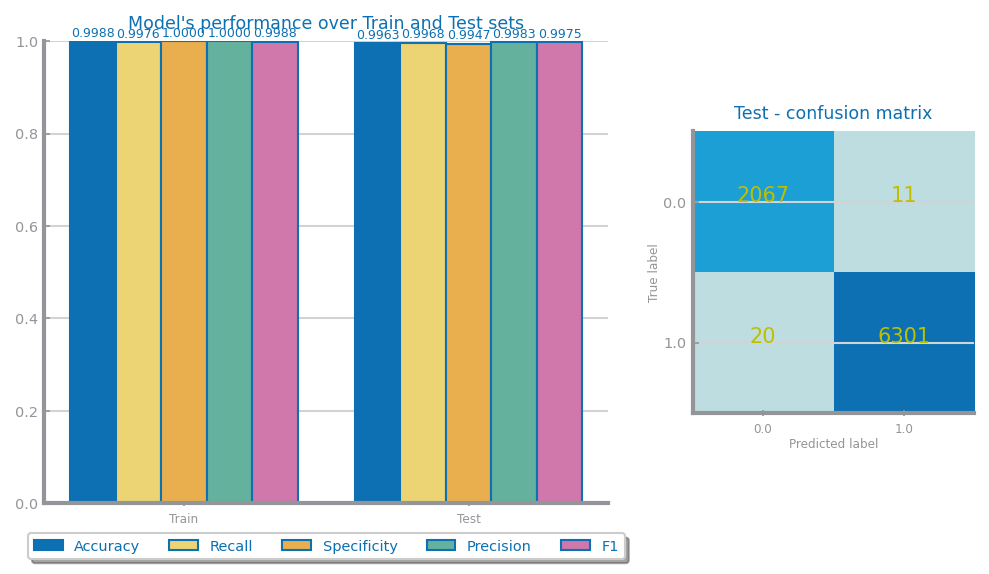

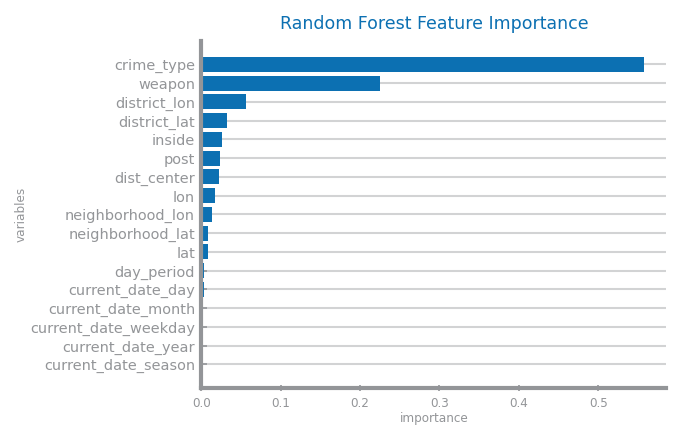

In [11]:
#  RANDOM FOREST

iterations = train_config['iterations']
params = {
    'max_depth' : [5,10,15],
    'max_features' : [.1, .3, .5, .7, .9, 1.0],
    'n_estimators' : [5, 10, 25, 50, 75, 100, 150],
}

model = RandomForestClassifier(random_state = 0, n_jobs = -1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)

rf_train_predictions = []
rf_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_rf = RandomForestClassifier(max_depth=best[0],max_features=best[1],n_estimators=best[2],random_state=0, n_jobs=-1)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_rf.fit(trnX, trnY)
    times['RF']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_rf.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_rf.predict(tstX)
    times['RF']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    rf_train_predictions.append(prd_trn)
    rf_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'RF')

    variables = train.columns
    importances = clf_rf.feature_importances_
    importance_list.append(importances)
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], std[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}rf/seed_{counter}_rf_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}rf.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['RF'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Random Forest Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}RF_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.6972498000000087
train_predict time: 0.008500499999854583
zpredict: 0.0033931999998912943
1 zfit time: 0.7296984999998131
train_predict time: 0.013211500000124943
zpredict: 0.004347399999915069
2 zfit time: 0.7715245000001687
train_predict time: 0.010061899999982415
zpredict: 0.0028744999999616994
3 zfit time: 0.6969050000000152
train_predict time: 0.008258000000068932
zpredict: 0.0026818000001185283
4 zfit time: 0.7353502000000844
train_predict time: 0.014345800000000963
zpredict: 0.006396199999926466
5 zfit time: 0.7010857000000215
train_predict time: 0.008313299999826995
zpredict: 0.0032846999999947
6 zfit time: 0.8108604999999898
train_predict time: 0.008102699999881224
zpredict: 0.003265800000008312
7 zfit time: 0.7320799999999963
train_predict time: 0.013053899999931673
zpredict: 0.004484199999978955
8 zfit time: 0.8230587000000469
train_predict time: 0.007990299999846684
zpredict: 0.00334459999999126
9 zfit time: 0.8004084000001512
train_predict time: 0.0138779000

<Figure size 600x450 with 0 Axes>

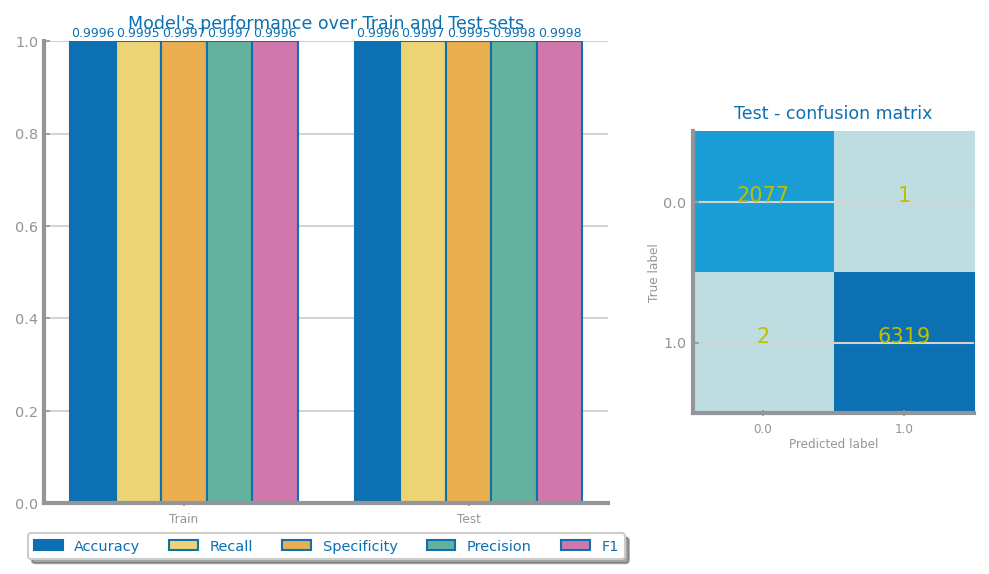

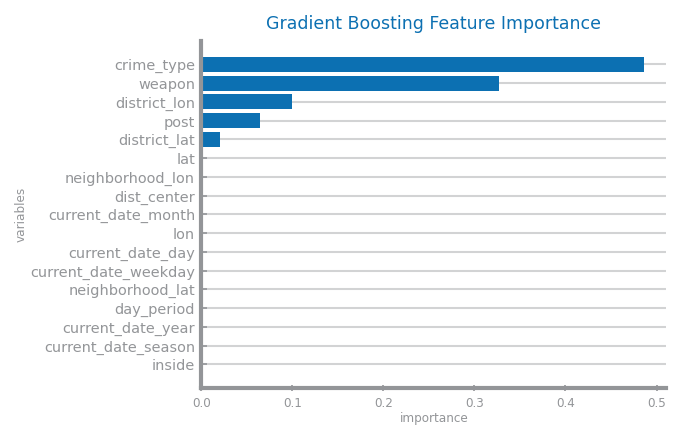

In [12]:
#  Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

iterations = train_config['iterations']

params = {
    'n_estimators' : [5, 10, 25, 50, 75, 100, 200],
    'max_depth' : [5, 10, 25],
    'learning_rate' : [.1, .5, .9]
}

model = GradientBoostingClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)

gb_train_predictions = []
gb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_gb = GradientBoostingClassifier(n_estimators=best[0], max_depth=best[1], learning_rate=best[2], random_state = 0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_gb.fit(trnX, trnY)
    times['GB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_gb.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_gb.predict(tstX)
    times['GB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    gb_train_predictions.append(prd_trn)
    gb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'GB')

    variables = train.columns
    importances = clf_gb.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_gb.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], np.std(importance_list),title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}gb/seed_{counter}_gb_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}gb.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]
fig = plt.figure()

model_importances['GB'] = list(zip(elems,mean_importance[indices]))

ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Gradient Boosting Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}GB_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

In [13]:
scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}
for i,v in model_scores.items():
    for m,v2 in v.items():
        mean = np.mean(v2)
        scores[i][m] = mean
print(scores)

{'NB': {'precision': 0.8411628802464381, 'recall': 0.6911881031482361, 'accuracy': 0.6693654006429337, 'auc': 0.6470858706309033, 'F1': 0.7588363004776378}, 'KNN': {'precision': 0.9293908547422844, 'recall': 0.9099825976902387, 'accuracy': 0.8802238361709728, 'auc': 0.8498421169394408, 'F1': 0.9195843325339726}, 'DT': {'precision': 0.9998385534388119, 'recall': 0.9797500395507039, 'accuracy': 0.9846410286938921, 'auc': 0.989634403798451, 'F1': 0.9896923691570118}, 'RF': {'precision': 0.9982572877059569, 'recall': 0.9968359436797977, 'accuracy': 0.9963090844148113, 'auc': 0.9957711960939891, 'F1': 0.9975461093960265}, 'GB': {'precision': 0.9998417721518986, 'recall': 0.9996835943679796, 'accuracy': 0.9996428146207881, 'auc': 0.999601181207089, 'F1': 0.9997626770034016}}


In [14]:
scores_n = {'precision' : [], 'recall' : [], 'accuracy' : [], 'auc' : [], 'F1' : []}

for k,v in scores.items():
    print(k,v)
    scores_n['precision'].append(v['precision'])
    scores_n['recall'].append(v['recall'])
    scores_n['accuracy'].append(v['accuracy'])
    scores_n['auc'].append(v['auc'])
    scores_n['F1'].append(v['F1'])

for v in scores_n.values():
    for i in v:
        print(i)

print()

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation != 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print() 

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation == 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print()

print(model_importances)

NB {'precision': 0.8411628802464381, 'recall': 0.6911881031482361, 'accuracy': 0.6693654006429337, 'auc': 0.6470858706309033, 'F1': 0.7588363004776378}
KNN {'precision': 0.9293908547422844, 'recall': 0.9099825976902387, 'accuracy': 0.8802238361709728, 'auc': 0.8498421169394408, 'F1': 0.9195843325339726}
DT {'precision': 0.9998385534388119, 'recall': 0.9797500395507039, 'accuracy': 0.9846410286938921, 'auc': 0.989634403798451, 'F1': 0.9896923691570118}
RF {'precision': 0.9982572877059569, 'recall': 0.9968359436797977, 'accuracy': 0.9963090844148113, 'auc': 0.9957711960939891, 'F1': 0.9975461093960265}
GB {'precision': 0.9998417721518986, 'recall': 0.9996835943679796, 'accuracy': 0.9996428146207881, 'auc': 0.999601181207089, 'F1': 0.9997626770034016}
0.8411628802464381
0.9293908547422844
0.9998385534388119
0.9982572877059569
0.9998417721518986
0.6911881031482361
0.9099825976902387
0.9797500395507039
0.9968359436797977
0.9996835943679796
0.6693654006429337
0.8802238361709728
0.98464102869

In [193]:
# a = pd.DataFrame(model_scores).reset_index()
# b = pd.melt(a, id_vars="index", var_name="model", value_name="score")
# c = b.explode('score')

# darkblue = '#0C70B2'


# plt.figure(figsize=(7.5,3))
# ax = sns.barplot(x='index', y='score', hue='model', data=c, ci = 'sd', errwidth=1, edgecolor = darkblue)
# ax.set_title('Baseline Model Scores')
# for i in range(len(ax.containers)):
#     ax.bar_label(ax.containers[i], fmt = '%1.4f', fontsize = 6)
# ax.legend(fontsize='x-small', title_fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# # plt.savefig(f'{image_dir}/{suffix}_scores.png', dpi=300, bbox_inches = 'tight')
